## Check GPU runtime

In [3]:
import torch
print(torch.__version__)  # Check installed version
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

2.2.2+cu118
True
1
NVIDIA GeForce RTX 3060 Laptop GPU


## Load image path and libraries

In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import cv2.dnn
import time

colors = np.random.uniform(0, 0, size=(1, 3))

image_path = "C:/Users/Lewis Do/Documents/Semester 6/CEH_seal/new_dataset/val/images/e2421765-4882-463b-8443-2c172fa97bf1.jpg"
im = cv2.imread(image_path)
im.shape

(640, 640, 3)

## Load ONNX model

In [5]:
import onnxruntime as ort

model_path = "C:/Users/Lewis Do/Documents/Semester 6/CEH_seal/YOLOv12/runs/best.onnx"
#model: cv2.dnn.Net = cv2.dnn.readNetFromONNX(model_path)

#blob = cv2.dnn.blobFromImage(im, scalefactor=1 / 255, size=(640, 640), swapRB=True)
#model.setInput(blob)
print("model Loaded Successfully")

model Loaded Successfully


In [6]:
def postprocessing(model_path, img: np.ndarray, conf_threshold=0.7, iou_threshold=0.45):
    #inference timetime
    model= cv2.dnn.readNetFromONNX(model_path)
    start_time = time.time()
    
    blob = cv2.dnn.blobFromImage(im, scalefactor=1 / 255, size=(640, 640), swapRB=True)
    model.setInput(blob)

    outputs = model.forward()

    inference_time = (time.time() - start_time) * 1000
    

    [h, w, _] = img.shape
    
    length = max((h, w))

    scale = length / 640

    outputs = np.array([cv2.transpose(outputs[0])])

    image = np.zeros((length, length, 3), np.uint8)
    
    image[0:h, 0:w] = img 

    rows = outputs.shape[1]

    boxes, scores, class_ids = [], [], []
    
    # debugging
    print("Output shape: ", outputs.shape)

    

    for i in range(rows):
        classes_scores = outputs[0][i][4:]
        (minScore, maxScore, minClassLoc, (x, maxClassIndex)) = cv2.minMaxLoc(classes_scores)
        if maxScore >= 0.25:
            box = [
                outputs[0][i][0] - (0.5 * outputs[0][i][2]),
                outputs[0][i][1] - (0.5 * outputs[0][i][3]),
                outputs[0][i][2],
                outputs[0][i][3],
            ]
            boxes.append(box)
            scores.append(maxScore)
            class_ids.append(maxClassIndex)

    # Apply non-max suppression
    result_boxes = cv2.dnn.NMSBoxes(boxes, scores, conf_threshold, iou_threshold)
    detections = []

    # iterate through NMS results to draw bounding boxes and labels
    for i in range(len(result_boxes)):
        index = result_boxes[i]
        box = boxes[index]
        detection = {
            "class_id": class_ids[index],
            "class_name": "Seal",
            "confidence": scores[index],
            "box": box,
            "scale": scale,
            "inference_time": inference_time,
        }
        detections.append(detection)
        
        #draw bounding box
        draw_bb(img, class_ids[index], scores[index],
                round(box[0] * scale), # x
                round(box[1] * scale), # y
                round(box[0] + box[2] * scale), # x_w
                round(box[1] + box[3] * scale) # y_h
        )

    return img, detections

In [7]:
def draw_bb(img: np.ndarray, class_id, confidence, x, y, x_w, y_h):
    label = f"object ({confidence:.2f})"
    color = colors[class_id]
    cv2.rectangle(img, (x, y), (x_w, y_h), color, 2) #image/start/end/color/thichness
    cv2.putText(img, label, (x-10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color,2) #font-scale = 0.5

In [8]:
result, detections = postprocessing(model_path, im)

Output shape:  (1, 8400, 5)


In [9]:
detections

[{'class_id': 0,
  'class_name': 'Seal',
  'confidence': 0.9335587620735168,
  'box': [262.8364715576172, 290.11537170410156, 121.91702, 160.35446],
  'scale': 1.0,
  'inference_time': 464.9970531463623}]

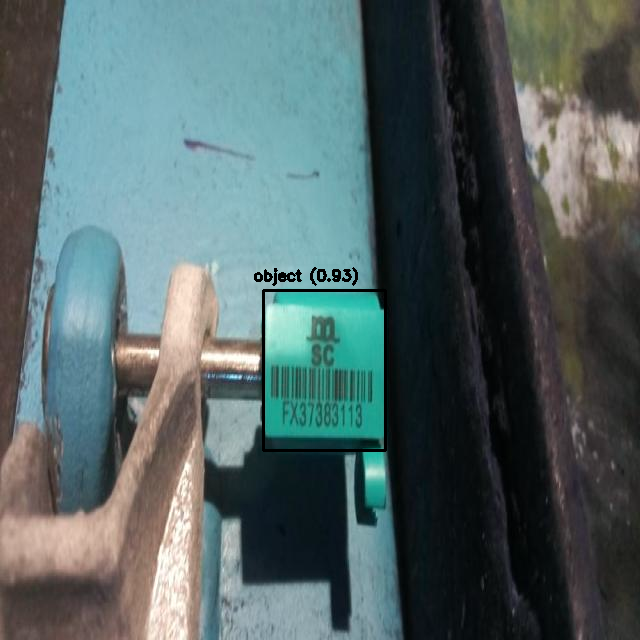

In [10]:
from PIL import Image

res = Image.fromarray(result)
res

Output shape:  (1, 8400, 5)
[{'class_id': 0, 'class_name': 'Seal', 'confidence': 0.8934037089347839, 'box': [156.3877716064453, 320.233154296875, 224.46188, 218.073], 'scale': 1.0, 'inference_time': 422.29461669921875}]


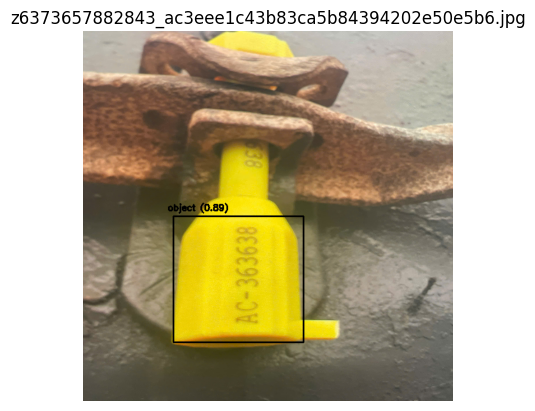

Output shape:  (1, 8400, 5)
[]


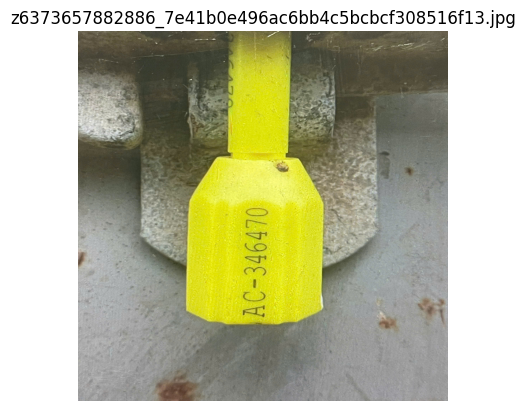

Output shape:  (1, 8400, 5)
[{'class_id': 0, 'class_name': 'Seal', 'confidence': 0.7867591977119446, 'box': [148.6882095336914, 236.17449951171875, 246.9652, 294.73004], 'scale': 1.0, 'inference_time': 432.05809593200684}]


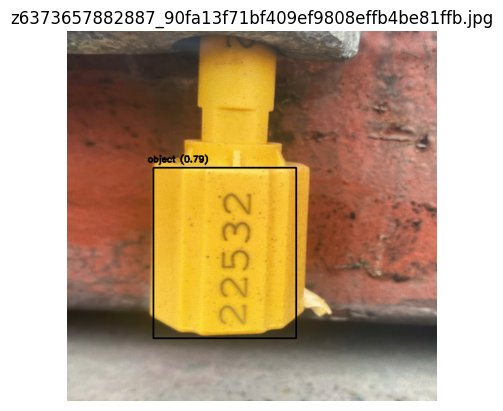

Output shape:  (1, 8400, 5)
[{'class_id': 0, 'class_name': 'Seal', 'confidence': 0.8631823658943176, 'box': [241.859619140625, 316.3406066894531, 203.17828, 194.06683], 'scale': 1.0, 'inference_time': 447.1292495727539}]


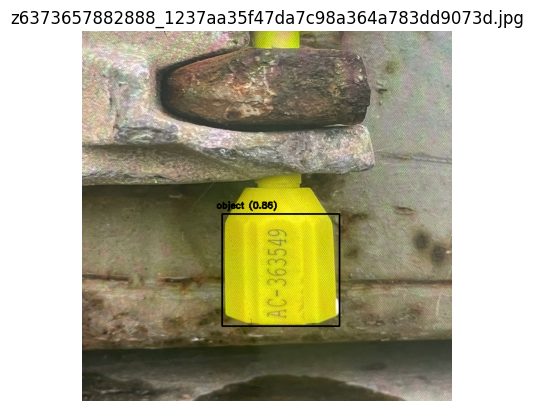

Output shape:  (1, 8400, 5)
[{'class_id': 0, 'class_name': 'Seal', 'confidence': 0.8604562878608704, 'box': [158.9752960205078, 341.788330078125, 209.80966, 202.79877], 'scale': 1.0, 'inference_time': 453.6771774291992}]


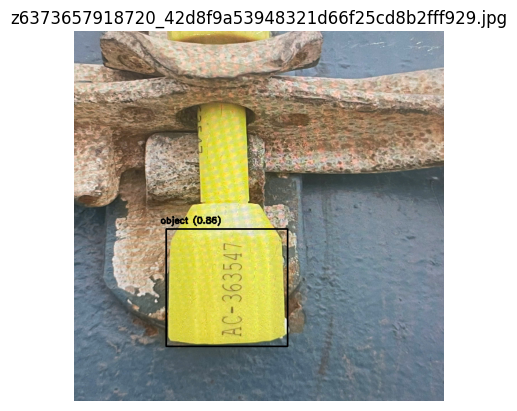

In [16]:
import os

file_dir = "C:/Users/Lewis Do/Documents/Semester 6/CEH_seal/new_dataset/seal-eva"
image_files = os.listdir(file_dir)

image_files = [file for file in image_files if file.endswith(".jpg")]

for image_file in image_files:
    im = cv2.imread(os.path.join(file_dir, image_file))
    im = cv2.resize(im, (640, 640))
    result, detections = postprocessing(model_path, im)
    print(detections)
    plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
    plt.title(image_file)
    plt.axis('off')
    plt.show()

